# Mask Fraction in Cell-Based Coadds

Notebook for mask fraction analyses for cell-based coadds.

## Load in imports and data

Last working stack: `d_2024_08_27`

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

# mean weighted variance
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.afw.math as afwMath

# plotting image with cell inputs
import lsst.geom as afwGeom

# interpolation mask threshold
import lsst.geom as geom

In [2]:
collection = 'u/mgorsuch/cell_coadds_tract_9813_d_2024_08_27/20240904T143002Z'

In [3]:
patch = 61

In [4]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

In [5]:
stitch_coadd = coadd.stitch()

In [6]:
cell_list_filled = list(coadd.cells.keys())

In [7]:
# generate all possible cell indices within a 2D arary

cell_list = []
cells_filled = [False] * coadd.grid.shape[0] * coadd.grid.shape[1]

index = 0 
for i in range(coadd.grid.shape[0]):
    for j in range(coadd.grid.shape[1]):
        # Index2D axes are reverse of 2D list
        cell_list.append(Index2D(x=j,y=i))

        if Index2D(x=j,y=i) in cell_list_filled:
            cells_filled[index]=True

        index += 1

In [9]:
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)

In [10]:
# arrange the number of inputs for each cell into a 2D grid:

x_cell_bin = np.arange(0,coadd.grid.shape[0]+1,1)
y_cell_bin = np.arange(0,coadd.grid.shape[1]+1,1)

inputs_list = np.zeros([coadd.grid.shape[0],coadd.grid.shape[1]])

# for cell in cell_list:
for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 
        
    num_cell_inputs = len(coadd.cells[cell].inputs)
    x_index = cell.x
    y_index = cell.y
        
    inputs_list[y_index][x_index] = num_cell_inputs

In [11]:
# create and configure stats control object as seen in assemble_cell_coadd task
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

## Variation in INTRP mask fraction

### Create total input warp map (exclude inputs with `EDGE` mask)

Find a way to either load/calculate total number of possible input warps per cell prior to mask information.

Warps are currently thrown out in `AssembleCellCoaddTask` for:
- `EDGE` mask within cell bounding box
- weight of warp input image is not finite

Iteratite through the input warps and count which ones are considered for each cell. Only exclude warps with overlapping `EDGE` masks within cells. Other mask fractions will remove from total inputs early.

In [12]:
accTask = AssembleCellCoaddTask()

total_inputs_list = np.zeros([coadd.grid.shape[0],coadd.grid.shape[1]])
edge = afwImage.Mask.getPlaneBitMask("EDGE")

for warp_visit in visits:
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = warp_visit)
 
    for index, cell_index in enumerate(cell_list):

        # check if the cell is filled, skip if not
        if not (cells_filled[index]):
            continue 
        
        cell = coadd.cells[cell_index]
        
        bbox = cell.outer.bbox
        masked_im = warp[bbox].getMaskedImage()

        # check if the warp covers the cell
        if (masked_im.getMask().array & edge).any():
            continue

        # ensure that weights are finite, skip cell if not
        weight = accTask._compute_weight(masked_im, statsCtrl)
        if not np.isfinite(weight):
            continue

        x_index = cell_index.x
        y_index = cell_index.y
        total_inputs_list[y_index][x_index] += 1
        
    del warp

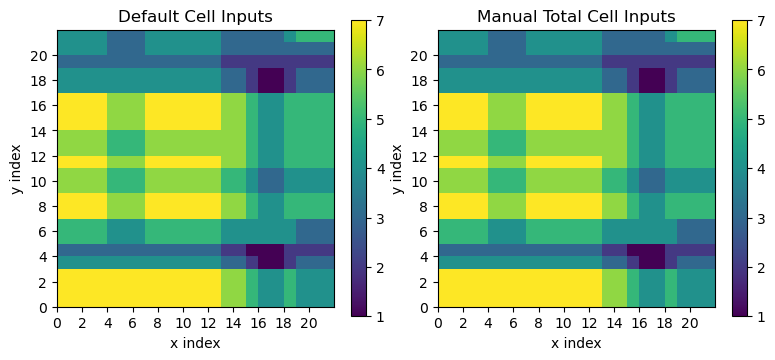

In [13]:
x_cell_bin = np.arange(0,coadd.grid.shape[0]+1,1)
y_cell_bin = np.arange(0,coadd.grid.shape[1]+1,1)

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

cell_inputs = ax1.pcolormesh(x_cell_bin, 
                             y_cell_bin, 
                             inputs_list, 
                             shading='auto', 
                             vmin=inputs_list.min(), 
                             vmax=inputs_list.max())

ax1.set_title(f"Default Cell Inputs")
ax1.set_xlabel("x index")
ax1.set_ylabel("y index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_inputs, ax=ax1, cmap='viridis', shrink=0.4)

cell_total_inputs = ax2.pcolormesh(x_cell_bin, 
                                   y_cell_bin,
                                   total_inputs_list, 
                                   shading='auto', 
                                   vmin=total_inputs_list.min(), 
                                   vmax=total_inputs_list.max(),)

ax2.set_title(f"Manual Total Cell Inputs")
ax2.set_xlabel("x index")
ax2.set_ylabel("y index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_total_inputs, ax=ax2, cmap='viridis', shrink=0.4)

plt.show()

Now it's apparant that the default number of cell inputs that come from running the tasks produce the total number of considered inputs. It's time to rerun the above, but calculate a test mask fraction for interpolation effects.

### Implement mask fraction for interpolation

The goal here is to understand what percentage of pixels are masked within each warp, and how that percentage is coadded to see the mask fraction of the coadd. Care must be taken, as the warping process leaves us with "mask fraction" pixels, but these conserve the total percentage of masked pixels across warps and coadds.

Another value of interest is the input fraction, which indicates how many input warps are discarded for having too many masked pixels. There are two thresholds explored here, 10% and 5%, over which a warp is discarded from the coadd. Note that the threshold is set to 85% when looking at the total coadded mask fraction, though no warps are discarded in this case.

In [13]:
accTask = AssembleCellCoaddTask()

weighted_mask_frac1 = np.zeros([coadd.grid.shape[0],coadd.grid.shape[1]]) # track coadded average mask fraction for each cell
cell_inputs1 = np.zeros([coadd.grid.shape[0],coadd.grid.shape[1]]) # track remaining fraction of input warps with 10% threshold
cell_inputs2 = np.zeros([coadd.grid.shape[0],coadd.grid.shape[1]]) # track remaining fraction of input warps with 5% threshold
total_weights = np.zeros([coadd.grid.shape[0],coadd.grid.shape[1]]) # used to weight weighted_mask_frac1 at the end

cell_list = list(coadd.cells.keys())

for visit in visits:
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = visit)
    
    mask_frac_warp = butler.get('deepCoadd_directWarp_maskedFraction',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = visit)

    for index, cell_index in enumerate(cell_list):
        
        # check if the cell is filled, skip if not
        if not (cells_filled[index]):
            continue
            
        cell = coadd.cells[cell_index]
        
        bbox = cell.outer.bbox
        masked_im = warp[bbox].getMaskedImage()
        mask_frac_im = mask_frac_warp[bbox].array

        # check if cell uses warp, skip cell if not
        cell_inputs = list(cell.inputs)
        cell_visits = [input.visit for input in cell_inputs]
        if not (np.isin(visit, cell_visits)):
            continue

        # skip warp for this cell if intrp mask fraction is too high
        total_pixels = bbox.area
        mask_frac = np.nansum(mask_frac_im[np.where(np.isfinite(mask_frac_im))])/total_pixels

        if mask_frac >= 0.85:
            print("mask frac reached")
            continue

        # coadd the weighted mask fraction for this cell
        input_weight = accTask._compute_weight(masked_im, statsCtrl)
        weight_mask_frac = input_weight * mask_frac_im
        
        x_index = cell_index.x
        y_index = cell_index.y

        weighted_mask_frac1[y_index][x_index] += np.nansum(weight_mask_frac) / total_pixels
        total_weights[y_index][x_index] += input_weight
        
        if mask_frac >= 0.10:
            continue
            
        cell_inputs1[y_index][x_index] += 1

        if mask_frac >= 0.05:
            continue
    
        cell_inputs2[y_index][x_index] += 1

    del warp
    del mask_frac_warp

# generate input fractions for both threshold amounts
inputs_list_masked = ma.masked_where(inputs_list == 0.0, inputs_list) 
cell_input_frac1 = cell_inputs1 / inputs_list_masked
cell_input_frac2 = cell_inputs2 / inputs_list_masked 

# generate final weighted mask fraction using total weights
total_weights = ma.masked_where(inputs_list == 0.0, total_weights)
weighted_mask_frac1 = ma.masked_where(inputs_list == 0.0, weighted_mask_frac1) / total_weights

Cut out the exta 50 empty side pixels in the stitched coadd.

In [14]:
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getBegin()+(geom.Extent2I(50, 50))))
bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getMax()-(geom.Extent2I(50, 50))))
cutout = stitch_coadd.image[bbox]

extent = 0, cutout.getDimensions()[0], 0, cutout.getDimensions()[1]

#### Coadd mask fraction + Input Warp Fraction plots

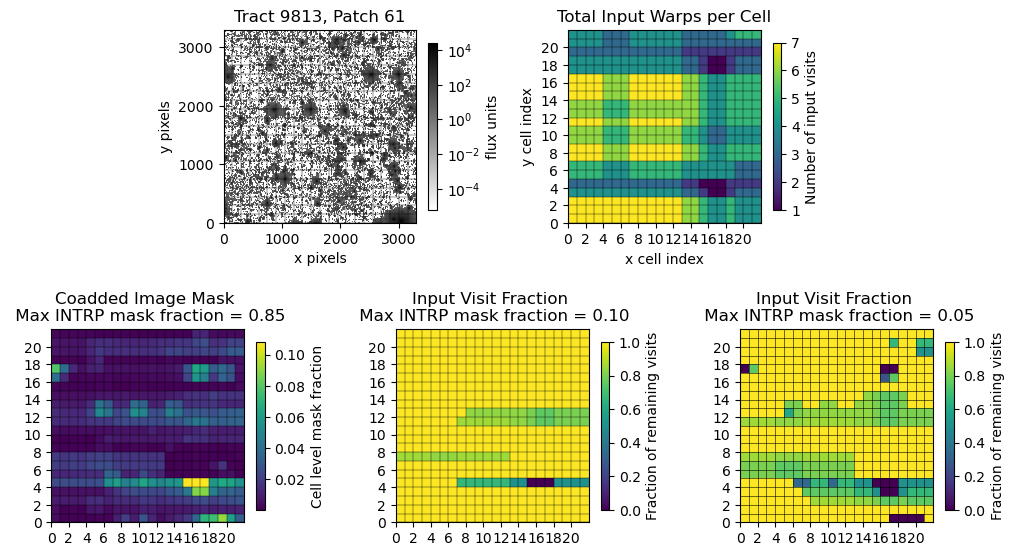

In [51]:
x_cell_bin = np.arange(0,coadd.grid.shape[0]+1,1)
y_cell_bin = np.arange(0,coadd.grid.shape[1]+1,1)

fig = plt.figure(figsize=(12,7))
plt.subplots_adjust(hspace=0.25, wspace=1.5)

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,1), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,3), colspan=2)
ax3 = plt.subplot2grid((2,6), (1,0), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,2), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,4), colspan=2)

# HSC image
stitched_image = ax1.imshow(np.flip(cutout.array, axis=0),
                                 cmap='gray_r',
                                 norm='log',
                                 extent=extent,)

hlines = [ax1.axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, cutout.getDimensions()[0], 150)]
vlines = [ax1.axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, cutout.getDimensions()[0], 150)]

ax1.set_title(f"Tract 9813, Patch {patch}")
ax1.set_xlabel("x pixels")
ax1.set_ylabel("y pixels")
ax1.set_aspect('equal')

fig.colorbar(stitched_image, ax=ax1, cmap='viridis', shrink=0.7, label="flux units")

# cell inputs
cell_inputs = ax2.pcolormesh(x_cell_bin, 
                             y_cell_bin, 
                             inputs_list, 
                             shading='auto', 
                             vmin=inputs_list.min(), 
                             vmax=inputs_list.max())

hlines = [ax2.axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, coadd.grid.shape[0])]
vlines = [ax2.axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, coadd.grid.shape[1])]

ax2.set_title(f"Total Input Warps per Cell")
ax2.set_xlabel("x cell index")
ax2.set_ylabel("y cell index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_inputs, ax=ax2, cmap='viridis', shrink=0.7, label="Number of input visits")

# coadded mask fraction
cell_mask_frac1 = ax3.pcolormesh(x_cell_bin, 
                                   y_cell_bin,
                                   weighted_mask_frac1,
                                   shading='auto', 
                                   vmin=weighted_mask_frac1.min(), 
                                   vmax=weighted_mask_frac1.max(),)

hlines = [ax3.axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, coadd.grid.shape[0])]
vlines = [ax3.axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, coadd.grid.shape[1])]

ax3.set_title(f"Coadded Image Mask \n Max INTRP mask fraction = 0.85")
ax3.set_aspect('equal')
ax3.set_xticks(np.arange(0, 21, 2))
ax3.set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_mask_frac1, ax=ax3, cmap='viridis', shrink=0.7, label="Cell level mask fraction")

# Input fraction, with a 0.10 mask fraction threshold
cell_mask_frac1 = ax4.pcolormesh(x_cell_bin, 
                                   y_cell_bin,
                                   cell_input_frac1, 
                                   shading='auto', 
                                   vmin=0, 
                                   vmax=1,)

hlines = [ax4.axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, coadd.grid.shape[0])]
vlines = [ax4.axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, coadd.grid.shape[1])]

ax4.set_title(f"Input Visit Fraction \n Max INTRP mask fraction = 0.10")
ax4.set_aspect('equal')
ax4.set_xticks(np.arange(0, 21, 2))
ax4.set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_mask_frac1, ax=ax4, cmap='viridis', shrink=0.7, label="Fraction of remaining visits")

cell_mask_frac2 = ax5.pcolormesh(x_cell_bin, 
                                       y_cell_bin,
                                       cell_input_frac2, 
                                       shading='auto', 
                                       vmin=0, 
                                       vmax=1,)

hlines = [ax5.axhline(y=i, linestyle='-', lw=0.4, color='black') for i in range(0, coadd.grid.shape[0])]
vlines = [ax5.axvline(x=i, linestyle='-', lw=0.4, color='black') for i in range(0, coadd.grid.shape[1])]

ax5.set_title(f"Input Visit Fraction \n Max INTRP mask fraction = 0.05")
ax5.set_aspect('equal')
ax5.set_xticks(np.arange(0, 21, 2))
ax5.set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_mask_frac2, ax=ax5, cmap='viridis', shrink=0.7, label="Fraction of remaining visits")

plt.savefig("image_outputs/patch_61_m_frac.png", bbox_inches='tight')
plt.show()